# Group project - plant Pathology 2021
## Identify the category of foliar diseases in apple trees
### CPE 695A - Applied Machine Learning
### Semester Group project
### Off the Shelf - Classic Neural Network Architecture - Inception ResNet V2

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras
import PIL
from PIL import Image
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#from sklearn.preprocessing import MultiLabelBinarizer
import albumentations as A
#import shutil
#from keras.preprocessing import image
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2, ResNet50, Xception

pd.set_option("display.max_columns", None)

In [20]:
tf.test.is_built_with_cuda()

True

In [22]:
df = pd.read_csv('/Users/ashis/Downloads/3 - Applied Machine Learning CPE 695A/Kaggle/ML Group Project - Dataset/train.csv',index_col='image')

In [23]:
init_len = len(df)

with open('/Users/ashis/Downloads/3 - Applied Machine Learning CPE 695A/Kaggle/ML Group Project - Dataset/duplicates.csv', 'r') as file:
    duplicates = [x.strip().split(',') for x in file.readlines()]

In [24]:
for row in duplicates:
    unique_labels = df.loc[row].drop_duplicates().values
    if len(unique_labels) == 1:
        df = df.drop(row[1:], axis=0)
    else:
        df = df.drop(row, axis=0)
        
print(f'Dropping {init_len - len(df)} duplicate samples.')

Dropping 83 duplicate samples.


In [25]:
DATA_OUTPUT = '/Users/ashis/Downloads/3 - Applied Machine Learning CPE 695A/Kaggle/ML Group Project - Dataset/'
DATA_TRAIN_IMAGES_256 = os.path.join(DATA_OUTPUT, 'train_images_256')

In [26]:
df = df.reset_index()

In [27]:
df.labels.value_counts()

scab                               4818
healthy                            4624
frog_eye_leaf_spot                 3180
rust                               1815
complex                            1580
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             119
rust complex                         91
powdery_mildew complex               87
Name: labels, dtype: int64

In [28]:
#https://www.kaggle.com/shanmukh05/plant-pathology-2k21-baseline-tpu-training

count_dict = df.labels.value_counts()
label2id = {
    'scab': 0,
    'frog_eye_leaf_spot' : 1,
    'rust' : 2,
    'complex' : 3,
    'powdery_mildew' : 4,
}
NUM_CLASS = len(label2id)
id2label = dict([(value, key) for key, value in label2id.items()])
df["labels"] = df["labels"].map(lambda x : [i for i in x.split(" ") if i != "healthy"])
df["labels"] = df["labels"].map(lambda x : [label2id[i] for i in x])
df.head()

,image,labels
0,800113bb65efe69e.jpg,[]
1,8002cb321f8bfcdf.jpg,"[0, 1, 3]"
2,80070f7fb5e2ccaa.jpg,[0]
3,80077517781fb94f.jpg,[0]
4,800cbf0ff87721f8.jpg,[3]


In [29]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

In [30]:
#train_datagen = ImageDataGenerator(rescale = 1./255.,preprocessing_function=None,data_format=None,validation_split = 0.2)
#test_datagen = ImageDataGenerator(rescale = 1./255,preprocessing_function=None,data_format=None,validation_split = 0.2)

In [31]:
train_generator = train_datagen.flow_from_dataframe(dataframe = df,
                                                   directory = DATA_TRAIN_IMAGES_256,
                                                   target_size = (256,256),
                                                   x_col = 'image',
                                                   y_col = 'labels',
                                                   batch_size = 128,
                                                   color_mode = 'rgb',
                                                   class_mode = 'categorical',
                                                   subset = 'training')

test_generator = test_datagen.flow_from_dataframe(dataframe = df,
                                                 directory = DATA_TRAIN_IMAGES_256,
                                                 target_size = (256,256),
                                                 x_col = 'image',
                                                 y_col = 'labels',
                                                 batch_size = 128,
                                                 color_mode = 'rgb',
                                                 class_mode = 'categorical',
                                                 subset = 'validation')

Found 14840 validated image filenames belonging to 5 classes.
Found 3709 validated image filenames belonging to 5 classes.


In [32]:
imgs, labels = next(train_generator)

In [33]:
def plotImages(images_arr):
    fig, axes = plt.subplots(8, 16, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

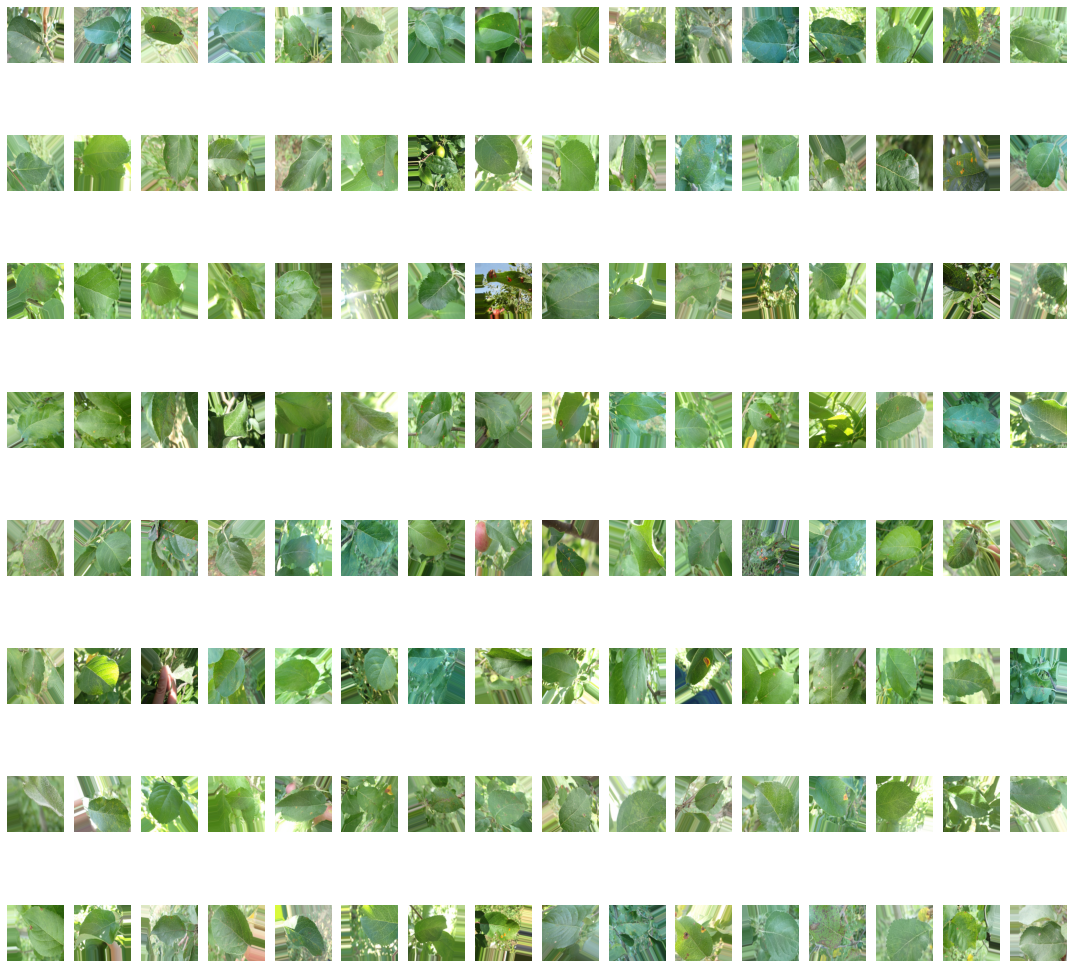

In [34]:
plotImages(imgs)

### Transfer Learning
Transfer learning is the process of using frozen weights from a large pre-trained model for a downstream task which is in our case classifying leaf diseases. The output/top layer of a pretrained layer is a dense layer containing number of nodes = number of output classes. All the models here are pre-trained on 'imagenet' hence they have a output/top layer of 1000 nodes. We will have to replace the output/top layer with our own dense layer with 6 nodes (for 6 classes).

I am going to be using Inception ResNet v2.

In [130]:
model_1 = InceptionResNetV2(weights='imagenet', 
                            include_top=False, input_shape=(256, 256, 3))

In [131]:
model_1.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_812 (Conv2D)             (None, 127, 127, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_812 (BatchN (None, 127, 127, 32) 96          conv2d_812[0][0]                 
__________________________________________________________________________________________________
activation_812 (Activation)     (None, 127, 127, 32) 0           batch_normalization_812[0][0]    
________________________________________________________________________________

In [132]:
import efficientnet.tfkeras as efn

In [133]:
model_2 = efn.EfficientNetB1(include_top=False, weights='imagenet',
                             input_shape=(256, 256, 3))

In [134]:
model_2.summary()

Model: "efficientnet-b1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [98]:
print(model_1.input)
print(model_1.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'")
KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 1536), dtype=tf.float32, name=None), name='conv_7b_ac/Relu:0', description="created by layer 'conv_7b_ac'")


In [99]:
print(model_2.input)
print(model_2.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_8'), name='input_8', description="created by layer 'input_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1280), dtype=tf.float32, name=None), name='top_activation/mul:0', description="created by layer 'top_activation'")


### To the InceptionResNet block and the efficientNetB1 block we add 2 sets of Dense and dropout layers before the final output layer. Final output layer contains same units as the number of classes to be predicted.

### We make sure we freeze the weights of the Resnet and efficientnet blocks. And only train the weights of extra added layers. 

In [135]:
seed = 1200
tf.random.set_seed(seed)

In [152]:
new_model_1 = tf.keras.Sequential([
    model_1, ## InceptionResnetV2 or EfficientNetB01 pretrained on image net.
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.20),
    Dense(256, activation='relu'),
    Dropout(0.20),
    Dense(NUM_CLASS, 
        kernel_initializer=keras.initializers.RandomUniform(),
        bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
])

# Freezing the weights
for layer in new_model_1.layers[:-6]:
    layer.trainable=False
    
new_model_1.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
module_wrapper_126 (ModuleWr (None, 1536)              0         
_________________________________________________________________
module_wrapper_127 (ModuleWr (None, 512)               786944    
_________________________________________________________________
module_wrapper_128 (ModuleWr (None, 512)               0         
_________________________________________________________________
module_wrapper_129 (ModuleWr (None, 256)               131328    
_________________________________________________________________
module_wrapper_130 (ModuleWr (None, 256)               0         
_________________________________________________________________
module_wrapper_131 (ModuleWr (None, 5)               

In [144]:
new_model_2 = tf.keras.Sequential([
    model_2, ### EfficientNetB01
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.20),
    keras.layers.Dense(NUM_CLASS, 
        kernel_initializer=keras.initializers.RandomUniform(),
        bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
])

# Freezing the weights
for layer in new_model_2.layers[:-6]:
    layer.trainable=False
    
new_model_2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Functional) (None, 8, 8, 1280)        6575232   
_________________________________________________________________
module_wrapper_120 (ModuleWr (None, 1280)              0         
_________________________________________________________________
module_wrapper_121 (ModuleWr (None, 512)               655872    
_________________________________________________________________
module_wrapper_122 (ModuleWr (None, 512)               0         
_________________________________________________________________
module_wrapper_123 (ModuleWr (None, 256)               131328    
_________________________________________________________________
module_wrapper_124 (ModuleWr (None, 256)               0         
_________________________________________________________________
module_wrapper_125 (ModuleWr (None, 5)               

In [113]:
METRIC = "val_f1_score"

def create_callbacks_1(metric = METRIC):
    
    cpk_path = '/Users/ashis/Downloads/3 - Applied Machine Learning CPE 695A/Kaggle/ML Group Project - Dataset/inceptionResNetV2.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.2,
        patience=3,
        verbose=1
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

def create_callbacks_2(metric = METRIC):
    
    cpk_path = '/Users/ashis/Downloads/3 - Applied Machine Learning CPE 695A/Kaggle/ML Group Project - Dataset/efficientNetB1.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.2,
        patience=3,
        verbose=1
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

In [145]:
from tensorflow.keras.optimizers import RMSprop,Adam

epochs = 40
optimizer = Adam(lr = 0.001)
new_model_1.compile(optimizer = optimizer,
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tfa.metrics.F1Score(num_classes = NUM_CLASS,average = "macro", name = "f1_score")])

new_model_2.compile(optimizer = optimizer,
             loss = 'binary_crossentropy',
             metrics = ['accuracy', tfa.metrics.F1Score(num_classes = NUM_CLASS,average = "macro", name = "f1_score")])

C:\Users\ashis\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [116]:
print(tf.__version__)

2.5.0


In [117]:
tf.test.is_built_with_cuda()

True

In [50]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16167376413729269522
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6292504576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7651963680022040264
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [51]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# my output was => ['/device:CPU:0']
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [146]:
f1 = tfa.metrics.F1Score(num_classes = NUM_CLASS,average = "macro", name = "f1_score")

callbacks = keras.callbacks.EarlyStopping(monitor="val_f1_score", patience=10, mode='max',verbose = 1,restore_best_weights=True)

In [151]:
new_model_2.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Functional) (None, 8, 8, 1280)        6575232   
_________________________________________________________________
module_wrapper_120 (ModuleWr (None, 1280)              0         
_________________________________________________________________
module_wrapper_121 (ModuleWr (None, 512)               655872    
_________________________________________________________________
module_wrapper_122 (ModuleWr (None, 512)               0         
_________________________________________________________________
module_wrapper_123 (ModuleWr (None, 256)               131328    
_________________________________________________________________
module_wrapper_124 (ModuleWr (None, 256)               0         
_________________________________________________________________
module_wrapper_125 (ModuleWr (None, 5)               

In [147]:
history_1 = new_model_1.fit(train_generator,epochs = epochs,validation_data = test_generator,verbose=1, callbacks = callbacks)

Epoch 1/40
116/116 [==============================] - 186s 2s/step - loss: 0.3758 - accuracy: 0.5400 - f1_score: 0.3449 - val_loss: 0.3281 - val_accuracy: 0.5411 - val_f1_score: 0.4697
Epoch 2/40
116/116 [==============================] - 178s 2s/step - loss: 0.3125 - accuracy: 0.6272 - f1_score: 0.4708 - val_loss: 0.2805 - val_accuracy: 0.6309 - val_f1_score: 0.5610
Epoch 3/40
116/116 [==============================] - 178s 2s/step - loss: 0.2957 - accuracy: 0.6484 - f1_score: 0.5025 - val_loss: 0.2531 - val_accuracy: 0.7193 - val_f1_score: 0.6068
Epoch 4/40
116/116 [==============================] - 187s 2s/step - loss: 0.2833 - accuracy: 0.6673 - f1_score: 0.5373 - val_loss: 0.2388 - val_accuracy: 0.7315 - val_f1_score: 0.5959
Epoch 5/40
116/116 [==============================] - 175s 2s/step - loss: 0.2752 - accuracy: 0.6683 - f1_score: 0.5437 - val_loss: 0.2474 - val_accuracy: 0.6544 - val_f1_score: 0.5835
Epoch 6/40
116/116 [==============================] - 175s 2s/step - loss: 

In [149]:
history_2 = new_model_2.fit(train_generator,epochs = epochs,validation_data = test_generator,verbose=1, callbacks = callbacks)

Epoch 1/40
116/116 [==============================] - 176s 1s/step - loss: 0.3227 - accuracy: 0.6059 - f1_score: 0.4587 - val_loss: 0.2339 - val_accuracy: 0.6606 - val_f1_score: 0.5918
Epoch 2/40
116/116 [==============================] - 175s 2s/step - loss: 0.2611 - accuracy: 0.6756 - f1_score: 0.5702 - val_loss: 0.2092 - val_accuracy: 0.7374 - val_f1_score: 0.6508
Epoch 3/40
116/116 [==============================] - 173s 1s/step - loss: 0.2476 - accuracy: 0.6926 - f1_score: 0.6005 - val_loss: 0.2045 - val_accuracy: 0.7687 - val_f1_score: 0.6700
Epoch 4/40
116/116 [==============================] - 173s 1s/step - loss: 0.2404 - accuracy: 0.7047 - f1_score: 0.6138 - val_loss: 0.2035 - val_accuracy: 0.7751 - val_f1_score: 0.6960
Epoch 5/40
116/116 [==============================] - 201s 2s/step - loss: 0.2328 - accuracy: 0.7086 - f1_score: 0.6220 - val_loss: 0.1951 - val_accuracy: 0.7776 - val_f1_score: 0.6950
Epoch 6/40
116/116 [==============================] - 230s 2s/step - loss: 

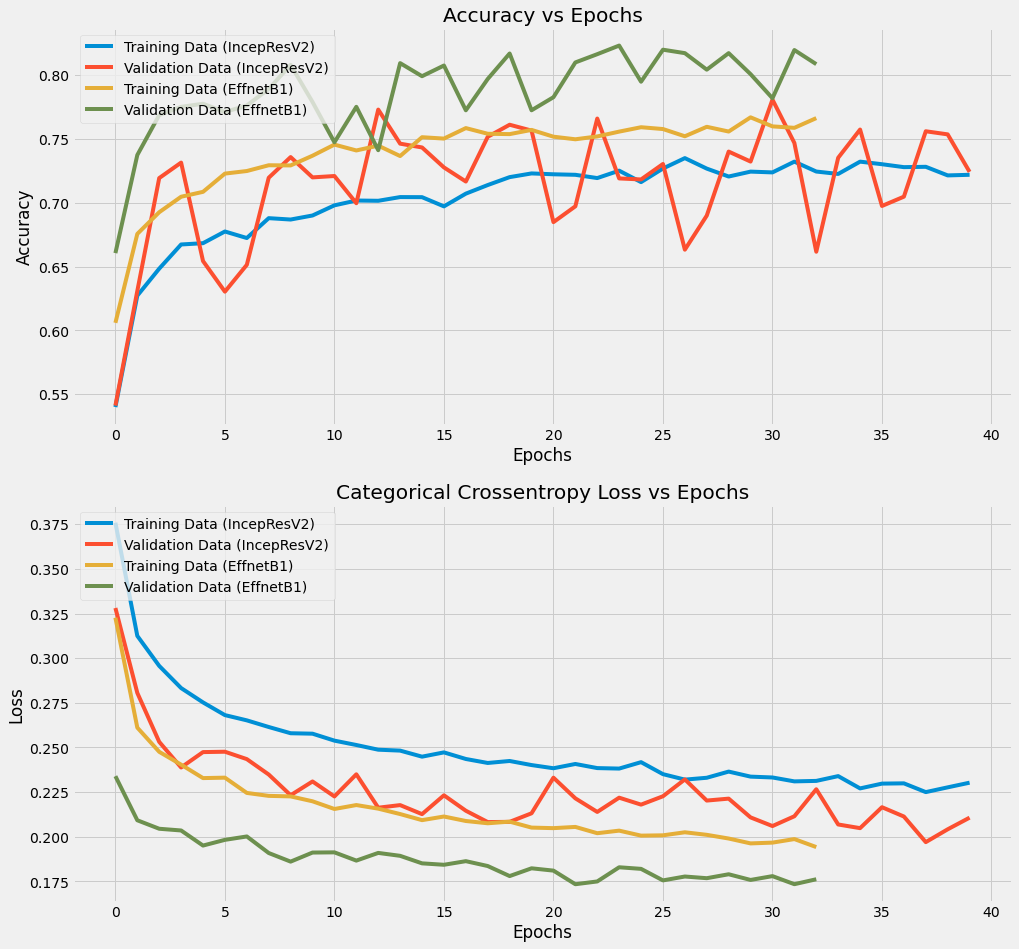

In [153]:
plt.style.use('fivethirtyeight')
figure, axis = plt.subplots(2, 1, figsize=(15,15))
axis.ravel()
axis[0].plot(history_1.history['accuracy'],label='Training Data (IncepResV2)')
axis[0].plot(history_1.history['val_accuracy'], label='Validation Data (IncepResV2)')

axis[0].plot(history_2.history['accuracy'],label='Training Data (EffnetB1)')
axis[0].plot(history_2.history['val_accuracy'], label='Validation Data (EffnetB1)')

axis[0].set(xlabel='Epochs',ylabel='Accuracy', title='Accuracy vs Epochs')
axis[0].legend(loc="upper left")

axis[1].plot(history_1.history['loss'], label='Training Data (IncepResV2)')
axis[1].plot(history_1.history['val_loss'], label='Validation Data (IncepResV2)')

axis[1].plot(history_2.history['loss'], label='Training Data (EffnetB1)')
axis[1].plot(history_2.history['val_loss'], label='Validation Data (EffnetB1)')

axis[1].set(xlabel='Epochs',ylabel='Loss', title='Categorical Crossentropy Loss vs Epochs')
axis[1].legend(loc="upper left")

plt.show()

In [154]:
inception_resnet_v2_results = {'train_loss':history_1.history['loss'],'train_accuracy':history_1.history['accuracy'],
                      'train_f1_score':history_1.history['f1_score'],'val_loss':history_1.history['val_loss'],
                      'val_accuracy':history_1.history['val_accuracy'],'val_f1_score':history_1.history['val_f1_score']}

efficient_net_b1_results = {'train_loss':history_2.history['loss'],'train_accuracy':history_2.history['accuracy'],
                      'train_f1_score':history_2.history['f1_score'],'val_loss':history_2.history['val_loss'],
                      'val_accuracy':history_2.history['val_accuracy'],'val_f1_score':history_2.history['val_f1_score']}

In [155]:
inception_resnet_v2_results = pd.DataFrame(inception_resnet_v2_results)
efficient_net_b1_results = pd.DataFrame(efficient_net_b1_results)

In [156]:
inception_resnet_v2_results.to_csv('inception_resnet_v2_results.csv',index=False)
efficient_net_b1_results.to_csv('efficient_net_b1_results.csv',index=False)

# THE END